In [1]:
import os
import timeit

import torch
import pandas as pd
from dataset.disprot_dataset import DisprotDataset, collate_fn
from dataset.utils import PadRightTo
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
import numpy as np



from net import Net

from main import plot_auc_and_loss, plot_roc_curve, save_auc_and_loss, train, test

d:\projects\pytorch_disprot\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
use_pssm = True
n_features = 21 if use_pssm else 1
train_epochs = 2


In [3]:

# Performance tuning
torch.multiprocessing.set_sharing_strategy('file_system')
torch.backends.cudnn.benchmark = True
######

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Load the data
train_data = pd.read_json(os.path.join("data/dataset/disorder_train.json"), orient='records', dtype=False)
test_data = pd.read_json(os.path.join("data/dataset/disorder_test.json"), orient='records', dtype=False)
# Defining the dataset


Using device: cuda


In [4]:
train_disorder = DisprotDataset(data=train_data, feature_root='data/features',
                                pssm=use_pssm, transform=PadRightTo(4000), target_transform=PadRightTo(4000))
test_disorder = DisprotDataset(data=test_data, feature_root='data/features',
                                pssm=use_pssm, transform=PadRightTo(4000), target_transform=PadRightTo(4000))
# Defining the dataloader for the training set and the test set
train_loader = DataLoader(train_disorder, batch_size=50, shuffle=True, num_workers=2, collate_fn=collate_fn,
                          pin_memory=True, pin_memory_device=device.type)
test_loader = DataLoader(test_disorder, batch_size=50, shuffle=True, num_workers=2, collate_fn=collate_fn,
                          pin_memory=True, pin_memory_device=device.type)


Importing sequences: 100%|██████████| 679/679 [00:14<00:00, 45.36it/s]


In [5]:

# Instantiate the model
net = Net(in_size=4000, in_features=n_features, out_size=4000).to(device)
net = nn.DataParallel(net).to(device)


In [6]:

# Define the loss function and the optimizer
criterion = nn.MSELoss(reduction='mean').cuda()

# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.000005)


In [7]:

all_train_loss, all_test_loss, all_test_aucs = np.array([]), np.array([]), np.array([])
for epoch in range(train_epochs):
    print(f"Epoch {epoch+1}")
    t0 = timeit.default_timer()
    _, losses = train(net, train_loader, optimizer, criterion, device, epoch)
    t1 = timeit.default_timer()
    print(f"  Train time: {t1-t0}")
    all_train_loss = np.concatenate((all_train_loss, losses))
    t2 = timeit.default_timer()
    print(f"  Concat: {t2-t1}")
    test_loss, test_auc = test(net, test_loader, criterion, device)
    t3 = timeit.default_timer()
    print(f"  Test: {t3-t2}")
    all_test_loss = np.append(all_test_loss, [test_loss])
    all_test_aucs = np.append(all_test_aucs, [test_auc])
    t4 = timeit.default_timer()
    print(f"  Appends: {t4-t3}")


Epoch 1
    Train: 0.00021540001034736633
    Zero grad: 0.002188399899750948
    Train Epoch: 1 [   0/1585 ( 0%)] Loss: 0.316
    Train Epoch: 1 [ 500/1585 (31%)] Loss: 0.255
    Train Epoch: 1 [1000/1585 (62%)] Loss: 0.266
    Train Epoch: 1 [1500/1585 (94%)] Loss: 0.236
  Train time: 19.86599709978327
  Concat: 0.00023399991914629936
    Test set: Average loss: 0.2598, AUC: 0.6164

  Test: 8.375203400384635
  Appends: 0.0002454998902976513
Epoch 2
    Train: 0.00024139974266290665
    Zero grad: 0.0013550003059208393
    Train Epoch: 2 [   0/1585 ( 0%)] Loss: 0.241
    Train Epoch: 2 [ 500/1585 (31%)] Loss: 0.330
    Train Epoch: 2 [1000/1585 (62%)] Loss: 0.349
    Train Epoch: 2 [1500/1585 (94%)] Loss: 0.295
  Train time: 9.960763899609447
  Concat: 0.00030610011890530586
    Test set: Average loss: 0.2586, AUC: 0.6282

  Test: 8.536297100130469
  Appends: 0.0001913001760840416


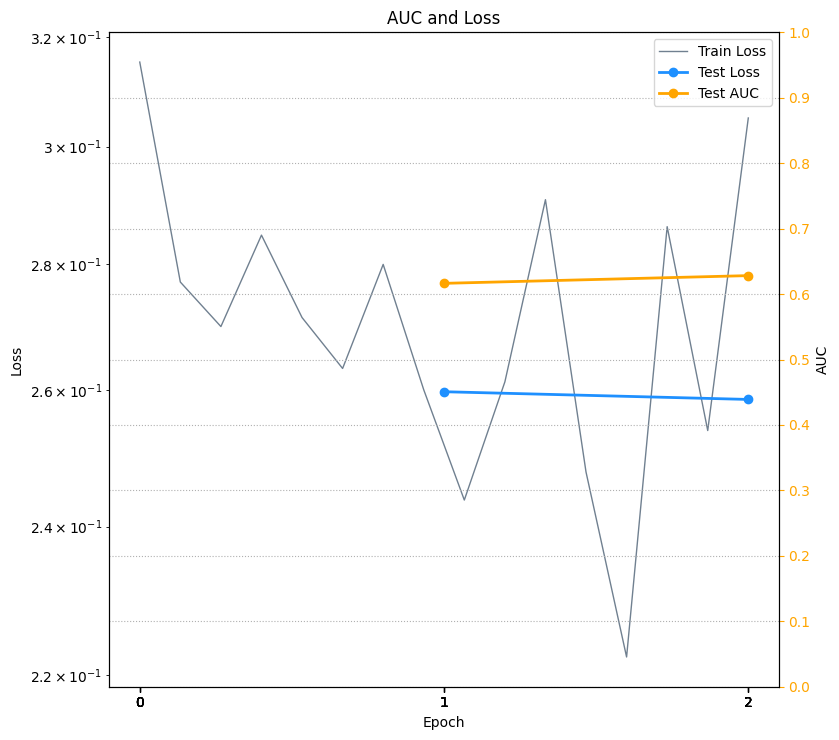

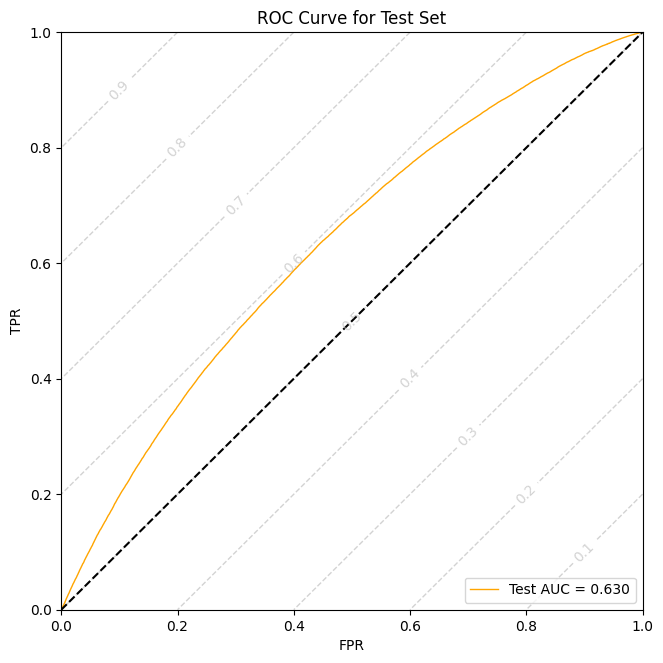

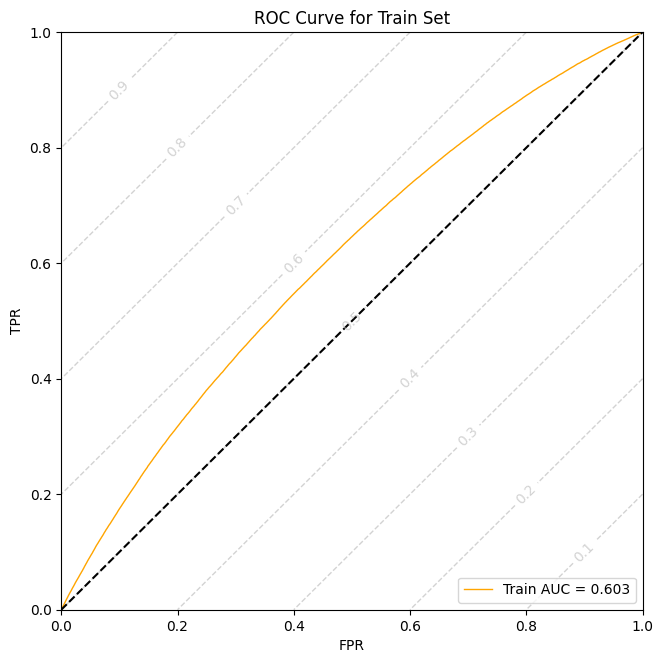

In [8]:

    # if epoch % 10 == 0:
    #     plot_auc_and_loss(all_train_loss, all_test_loss, all_test_aucs, epoch)

plot_auc_and_loss(all_train_loss, all_test_loss, all_test_aucs, epoch)
plot_roc_curve(net, test_loader, device)
plot_roc_curve(net, train_loader, device, set='Train')
save_auc_and_loss(
    all_train_loss,
    all_test_loss,
    all_test_aucs,
    epoch,
    "loss_and_auc_data.txt",
    "train_loss_and_auc_data.txt"
)